In [ ]:
!pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 43.4 MB/s eta 0:00:00


In [ ]:
import rasterio
import numpy as np
import os

# Base path to your JP2 files within the R10m directory
base_path = '/content/drive/MyDrive/Landsat Data/S2A_MSIL2A_20180417T042711_N0500_R133_T45QYE_20230808T113002.SAFE/GRANULE/L2A_T45QYE_A014716_20180417T043950/IMG_DATA/R10m'

# List of band files you want to stack, adjust the file names based on your actual files
bands = ['T45QYE_20180417T042711_B02_10m.jp2', 'T45QYE_20180417T042711_B03_10m.jp2', 'T45QYE_20180417T042711_B04_10m.jp2', 'T45QYE_20180417T042711_B08_10m.jp2']

# Create an empty list to hold data from each band
band_data = []

# Read each band into a numpy array and append to list
for band in bands:
    path = os.path.join(base_path, band)
    with rasterio.open(path) as src:
        band_array = src.read(1)  # Read the first (and only) band
        band_data.append(band_array)

# Stack arrays along a new third axis (band dimension)
stacked_array = np.stack(band_data, axis=-1)

# Define the path where the NumPy file will be saved
output_path = '/content/drive/MyDrive/Processed Data'

# Check if the directory exists, and if not, create it
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Save the stacked array to a NumPy file
output_file = os.path.join(output_path, 'high_res_image.npy')
np.save(output_file, stacked_array)

print("Stacked array shape:", stacked_array.shape)
print(f"Array saved to {output_file}")


Stacked array shape: (10980, 10980, 4)
Array saved to /content/drive/MyDrive/Processed Data/high_res_image.npy


In [ ]:
import numpy as np

# Path to the NumPy file
file_path = '/content/drive/MyDrive/Processed Data/high_res_image.npy'

# Load the file
data = np.load(file_path)

# Print basic information about the data
print("Data shape:", data.shape)
print("Data type:", data.dtype)


Data shape: (10980, 10980, 4)
Data type: uint16


In [ ]:
from skimage.transform import resize
import numpy as np

# Load your image data
image_data = np.load('/content/drive/MyDrive/Processed Data/high_res_image.npy')

# New dimensions: both width and height set to 2012
new_dimensions = (2012, 2012)  # height, width

# Check if the image has multiple bands/channels
if image_data.ndim == 3:
    # If the image is multichannel, ensure not to distort the channels
    resized_image = resize(image_data, (new_dimensions[0], new_dimensions[1], image_data.shape[2]), anti_aliasing=True)
else:
    # For a single channel image (2D)
    resized_image = resize(image_data, new_dimensions, anti_aliasing=True)

# Save the resized image
np.save('/content/drive/MyDrive/Processed Data/Sunda.npy', resized_image)

# Print new shape to confirm
print("Resized image shape:", resized_image.shape)


Resized image shape: (2012, 2012, 4)


In [ ]:
import numpy as np

# Load your image data
image_data = np.load('/content/drive/MyDrive/Processed Data/Sunda.npy')

# Check if the image data is three-dimensional and print the number of bands/channels
if image_data.ndim == 3:
    print("Number of bands/channels:", image_data.shape[2])
else:
    print("This is a single channel (2D) image.")


Number of bands/channels: 4


In [ ]:
# Import all packages needed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
import numpy as np

# Correctly set the base directory where your data is stored
datadir = '/content/drive/MyDrive/Processed Data'

# Load the image from the specific directory under your base directory
image = np.load(datadir + '/Sunda.npy')

# Extracting the mask_area values from the JSON
x1, y1, x2, y2 = [500, 200, 1000, 1000]

# Extracting the region of interest (ROI) from the image
roi = image[y1:y2, x1:x2]




In [ ]:
# Now also read in the mask file
mask = cv2.imread('/content/drive/MyDrive/Processed Data/mask.png', cv2.IMREAD_UNCHANGED)


# Because the mask file is in RGB which has 3 channels, so we should convert it into binary mask as array with only 0 and 1 values
binary_mask = np.where(mask[:,:,0] == 0, 1, 0)

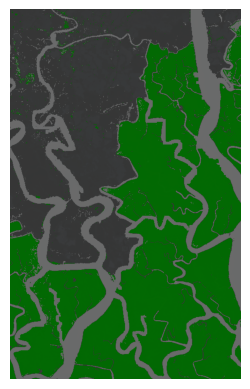

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Assuming datadir is already set to the correct directory containing your files
mask_path = '/content/drive/MyDrive/Processed Data/mask.png'  # Update this to the correct path for your mask image

# Load the mask image using PIL
mask_image = Image.open(mask_path)

# Ensure the image data is normalized for display
# Assuming the dtype of roi is float; if integer, you might need roi.astype(float) / 255
channel_1 = roi[:,:,0]  # Red
channel_2 = roi[:,:,1]  # Green
channel_3 = roi[:,:,2]  # Blue
rgb_image = np.stack([channel_1, channel_2, channel_3], axis=-1)

# Normalize the pixel values if not already in the range [0, 1] or [0, 255]
if rgb_image.max() > 1:
    rgb_image = rgb_image / 255.0  # Adjust this depending on the actual range of your data

# Plotting the RGB image
plt.imshow(rgb_image)
plt.imshow(mask_image, cmap='gray', alpha=0.4)  # Overlay the mask with some transparency
plt.axis('off')  # Turn off axis numbering
plt.show()


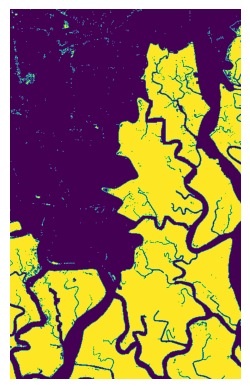

In [ ]:
# You can also plot the mask
plt.imshow(binary_mask)
plt.axis('off')
plt.show()

In [ ]:
## Another check needs to be done is their shape in first two dimensions
print(binary_mask.shape)
print(roi.shape)

(800, 500)
(800, 500, 4)


In [ ]:
# roi is your data with shape (800, 500, 21)
patches = []

# Iterate over the height and width of the roi, excluding the border pixels
for i in range(1, roi.shape[0] - 1):
    for j in range(1, roi.shape[1] - 1):
        # Extract a (3, 3, 21) patch centered around the pixel (i, j)
        patch = roi[i-1:i+2, j-1:j+2, :]
        patches.append(patch)

# Convert the list of patches to a numpy array
patches_array = np.array(patches)

print(patches_array.shape)

(397404, 3, 3, 4)


In [ ]:
# Trim the mask to exclude boundary labels
trimmed_mask = binary_mask[1:-1, 1:-1]

# Flatten the trimmed mask to get a 1D array of labels
labels = trimmed_mask.flatten()

print(labels.shape)

(397404,)


In [ ]:
# Assuming patches_array is your X and labels is your y
x_train, x_test, y_train, y_test = train_test_split(patches_array, labels, test_size=0.1, random_state=42)

In [ ]:
# Initially, we examine the quantity of each class present in the dataset
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))
# Identifying the class with the smaller count to balance the number in each class, for example, let it be 9396
num_class = 9396 # Adjust it to the amount you get

{0: 217900, 1: 179504}


In [ ]:
# Extract indices of both classes
indices_class_0 = np.where(labels == 0)[0]
indices_class_1 = np.where(labels == 1)[0]

# Randomly sample 9396 indices from class 0
sampled_indices_class_0 = np.random.choice(indices_class_0, num_class, replace=False)

# Combine the sampled indices with indices of class 1
combined_indices = np.concatenate([sampled_indices_class_0, indices_class_1])

# Extract the corresponding patches and labels
balanced_patches = patches_array[combined_indices]
balanced_labels = labels[combined_indices]


# Split the balanced dataset into training and testing sets with a 1:9 ratio
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(
    balanced_patches, balanced_labels, test_size=0.1, random_state=42
)

# Check the balance in y_train_balanced
unique, counts = np.unique(y_train_balanced, return_counts=True)
print(dict(zip(unique, counts)))

{0: 8470, 1: 161540}


In [ ]:
import os
import numpy as np

# Set the path where the files will be saved
save_path = '/content/drive/MyDrive/Processed Data'

# Assuming X_train_balanced, X_test_balanced, y_train_balanced, and y_test_balanced are already defined
np.save(os.path.join(save_path, 'X_train_balanced.npy'), X_train_balanced)
np.save(os.path.join(save_path, 'X_test_balanced.npy'), X_test_balanced)
np.save(os.path.join(save_path, 'y_train_balanced.npy'), y_train_balanced)
np.save(os.path.join(save_path, 'y_test_balanced.npy'), y_test_balanced)


In [ ]:
import os
import numpy as np

X_train = np.load(os.path.join('/content/drive/MyDrive/Processed Data', 'X_train_balanced.npy'))
X_test = np.load(os.path.join('/content/drive/MyDrive/Processed Data', 'X_test_balanced.npy'))
y_train = np.load(os.path.join('/content/drive/MyDrive/Processed Data', 'y_train_balanced.npy'))
y_test = np.load(os.path.join('/content/drive/MyDrive/Processed Data', 'y_test_balanced.npy'))


In [ ]:
X_train.shape

(170010, 3, 3, 4)

In [ ]:
y_train.shape

(170010,)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Assuming you have 3x3 pixel images with 21 channels
input_shape = (3, 3, 4)

# Define the model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # Adding another convolutional layer with padding
model.add(layers.MaxPooling2D((2, 2)))
# Add additional convolutional and pooling layers as needed
# ...

# Add dense layers for classification
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))  # Assuming 10 classes

# Compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Assuming your labels are in y_train and your data is in X_train
model.fit(X_train, y_train, epochs=10, validation_split=0.1)


Epoch 1/10
4782/4782 [==============================] - 19s 3ms/step - loss: 0.0813 - accuracy: 0.9794 - val_loss: 0.0514 - val_accuracy: 0.9851
Epoch 2/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0486 - accuracy: 0.9860 - val_loss: 0.0448 - val_accuracy: 0.9878
Epoch 3/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0386 - accuracy: 0.9893 - val_loss: 0.0349 - val_accuracy: 0.9906
Epoch 4/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0355 - accuracy: 0.9900 - val_loss: 0.0330 - val_accuracy: 0.9909
Epoch 5/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0334 - accuracy: 0.9907 - val_loss: 0.0418 - val_accuracy: 0.9886
Epoch 6/10
4782/4782 [==============================] - 14s 3ms/step - loss: 0.0321 - accuracy: 0.9910 - val_loss: 0.0323 - val_accuracy: 0.9915
Epoch 7/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0312 - accuracy: 0.9912 - val_loss: 0.0298 - val_ac

Epoch 1/10
4782/4782 [==============================] - 16s 3ms/step - loss: 0.0282 - accuracy: 0.9920 - val_loss: 0.0291 - val_accuracy: 0.9918
Epoch 2/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0277 - accuracy: 0.9922 - val_loss: 0.0310 - val_accuracy: 0.9916
Epoch 3/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0275 - accuracy: 0.9925 - val_loss: 0.0270 - val_accuracy: 0.9926
Epoch 4/10
4782/4782 [==============================] - 14s 3ms/step - loss: 0.0268 - accuracy: 0.9924 - val_loss: 0.0304 - val_accuracy: 0.9921
Epoch 5/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0266 - accuracy: 0.9926 - val_loss: 0.0274 - val_accuracy: 0.9925
Epoch 6/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0264 - accuracy: 0.9928 - val_loss: 0.0265 - val_accuracy: 0.9926
Epoch 7/10
4782/4782 [==============================] - 15s 3ms/step - loss: 0.0261 - accuracy: 0.9928 - val_loss: 0.0279 - val_ac

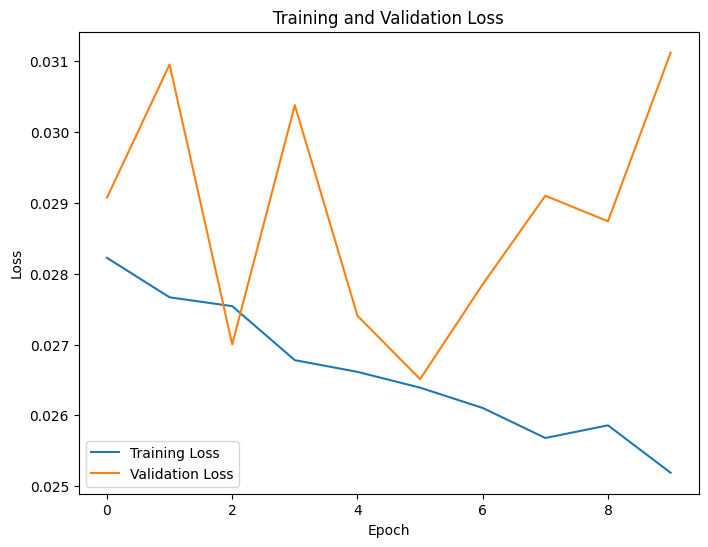

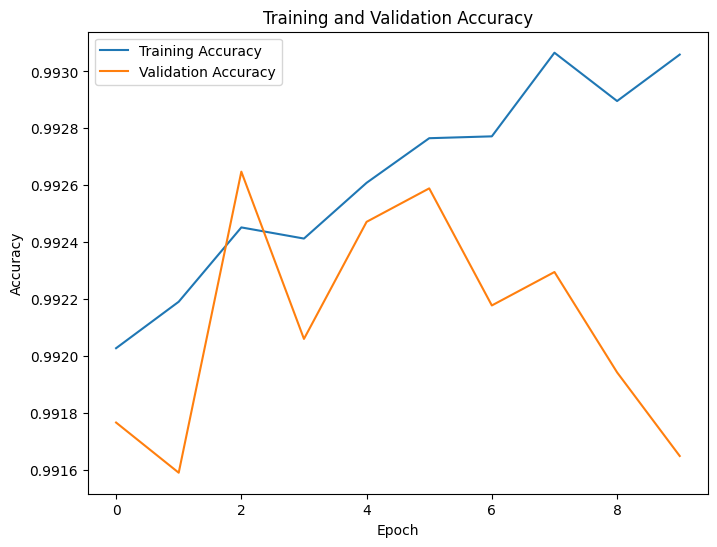

In [ ]:
import matplotlib.pyplot as plt

# Train the model and get the history object
history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()